In [37]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
from torch.hub import load_state_dict_from_url

In [2]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResMLPBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(channels, channels),
            nn.BatchNorm1d(channels),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(channels, channels),
            nn.BatchNorm1d(channels),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.fc2(self.fc1(x))
        out += x
        return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, in_channels=3, fc_size=2048, out_dim=64, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(in_channels, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Sequential(
            nn.Linear(512 * block.expansion, fc_size),
            nn.BatchNorm1d(fc_size),
            nn.ReLU(inplace=True),
            ResMLPBlock(fc_size),
            nn.Linear(fc_size, out_dim)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        avepool = self.avgpool(x)
        avepool = torch.flatten(avepool, 1)
        out = self.fc(avepool)

        return out, avepool

def _resnet(arch, block, layers, progress, **kwargs):
    return ResNet(block, layers, **kwargs)
    
def resnet18(progress=True, **kwargs):
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], progress, **kwargs)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dim = 64, fc_size = 2048):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc_size = fc_size
        
        self.out_dim = self.latent_dim * 2
        self.encoder = resnet18( in_channels=in_channels, fc_size=fc_size, out_dim=self.out_dim)
    
    def forward(self, x):
        z, ap = self.encoder(x)
        return z.chunk(2, dim=1)

In [4]:
def reparameterize(mu, sigma, std=1):
    eps = mu.new(mu.shape).normal_(0, std)
    return mu + sigma * eps

In [5]:
class ImageDataset(Dataset):
    def __init__(self,root_folder,transform):
        self.transform=transform
        self.img_folder=root_folder+'img/'

        self.image_names=[i for i in os.listdir(self.img_folder) if '.jpg' in i]
        self.attr = pd.read_csv(root_folder+'attr.csv').replace(-1,0)
        _ = self.attr.pop('image_id')
        
        self.num_feat = len(self.attr.columns)
        self.order = list(self.attr.columns)
        
        self.attr = self.attr.values
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)
        label = torch.tensor(self.attr[index], dtype = torch.float)

        return image, label

In [6]:
from torch.nn.utils import spectral_norm
from torch.nn.init import orthogonal_


def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        orthogonal_(m.weight)
        m.bias.data.fill_(0.)

def snlinear(in_features, out_features):
    return spectral_norm(nn.Linear(in_features=in_features, out_features=out_features))

def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    return spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias))

def snconvtrans2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, dilation=1, groups=1, bias=True):
    return spectral_norm(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                            padding=padding, output_padding=output_padding, dilation=dilation, groups=groups, bias=bias))


class Self_Attn(nn.Module):
    """ Self attention Layer"""

    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_attn = snconv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """
            inputs :
                x : input feature maps(B X C X W X H)
            returns :
                out : self attention value + input feature
        """
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)
        # Out
        out = x + self.sigma*attn_g
        return out


class NoiseInjection(nn.Module):
    def __init__(self, channel, size=1):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channel, size, size))

    def forward(self, image):
        one_channel = image[:,0:1,:,:]
        noise = one_channel.new(one_channel.shape).normal_(0, 1)
        out = image + self.weight * noise
        return out

class GenIniBlock(nn.Module):
    def __init__(self, z_dim, out_channels, size=1, add_noise=True):
        super().__init__()
        self.out_channels = out_channels
        self.add_noise = add_noise
        self.snlinear0 = snlinear(in_features=z_dim, out_features=out_channels * 4 * 4)
        if add_noise:
            self.noise0 = NoiseInjection(out_channels, size)

    def forward(self, z):
        act0 = self.snlinear0(z)
        act0 = act0.view(-1, self.out_channels, 4, 4)
        if self.add_noise:
            act0 = self.noise0(act0)

        return act0

class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size=1, add_noise=True):
        super().__init__()
        self.conv_1 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.conv_2 = snconv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.add_noise = add_noise
        if add_noise:
            self.noise1 = NoiseInjection(out_channels, size)
            self.noise2 = NoiseInjection(out_channels, size)
        self.conv_0 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.upsample = lambda x: F.interpolate(x, scale_factor=2, mode='nearest')

    def forward(self, x,):
        x0 = x

        x = self.relu(self.bn1(x))
        x = self.upsample(x)  # upsample
        x = self.conv_1(x)
        if self.add_noise:
            x = self.noise1(x)
        x = self.relu(self.bn2(x))
        x = self.conv_2(x)
        if self.add_noise:
            x = self.noise2(x)
        x0 = self.upsample(x0)  # upsample
        x0 = self.conv_0(x0)

        out = x + x0
        return out

class Generator(nn.Module):
    r'''SAGAN Generator

    Args:
        latent_dim: latent dimension
        conv_dim: base number of channels
        image_size: image resolution
        out_channels: number of output channels
        add_noise: whether to add noises to each conv layer
        attn: whether to add self-attention layer
    '''

    def __init__(self, latent_dim, conv_dim=32, image_size=128, out_channels=3, add_noise=True, attn=True):
        super().__init__()

        self.latent_dim = latent_dim
        self.conv_dim = conv_dim
        self.image_size = image_size
        self.add_noise = add_noise
        self.attn = attn

        self.block0 = GenIniBlock(latent_dim, conv_dim * 16, 4, add_noise=add_noise)
        self.block1 = GenBlock(conv_dim * 16, conv_dim * 16, size=8, add_noise=add_noise)
        self.block2 = GenBlock(conv_dim * 16, conv_dim * 8, size=16, add_noise=add_noise)
        if image_size == 64:
            self.block3 = GenBlock(conv_dim * 8, conv_dim * 4, size=32, add_noise=add_noise)
            if attn:
                self.self_attn1 = Self_Attn(conv_dim * 4)
            self.block4 = GenBlock(conv_dim * 4, conv_dim * 2, size=64, add_noise=add_noise)
            conv_dim = conv_dim * 2
        elif image_size == 128:
            self.block3 = GenBlock(conv_dim * 8, conv_dim * 4, add_noise=add_noise)
            if attn:
                self.self_attn1 = Self_Attn(conv_dim * 4)
            self.block4 = GenBlock(conv_dim * 4, conv_dim * 2, add_noise=add_noise)
            # self.self_attn2 = Self_Attn(conv_dim*2)
            self.block5 = GenBlock(conv_dim * 2, conv_dim, add_noise=add_noise)
        else: # image_size == 256 or 512
            self.block3 = GenBlock(conv_dim * 8, conv_dim * 8, add_noise=add_noise)
            self.block4 = GenBlock(conv_dim * 8, conv_dim * 4, add_noise=add_noise)
            if attn:
                self.self_attn1 = Self_Attn(conv_dim * 4)
            self.block5 = GenBlock(conv_dim * 4, conv_dim * 2, add_noise=add_noise)
            self.block6 = GenBlock(conv_dim * 2, conv_dim, add_noise=add_noise)
            if image_size == 512:
                self.block7 = GenBlock(conv_dim, conv_dim, add_noise=add_noise)

        self.bn = nn.BatchNorm2d(conv_dim, eps=1e-5, momentum=0.0001, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.toRGB = snconv2d(in_channels=conv_dim, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

        self.apply(init_weights)

    def forward(self, z):
        out = self.block0(z)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        if self.attn:
            out = self.self_attn1(out)
        out = self.block4(out)
        if self.image_size > 64:
            out = self.block5(out)
            if self.image_size == 256 or self.image_size == 512:
                out = self.block6(out)
                if self.image_size == 512:
                    out = self.block7(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.toRGB(out)
        out = self.tanh(out)
        return out

In [13]:

class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_1 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.conv_2 = snconv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.conv_0 = snconv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

        self.relu = nn.ReLU()
        self.downsample = nn.AvgPool2d(2)
        self.ch_mismatch = False
        if in_channels != out_channels:
            self.ch_mismatch = True

    def forward(self, x, downsample=True):
        x0 = x

        x = self.relu(x)
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.conv_2(x)
        if downsample:
            x = self.downsample(x)

        if downsample or self.ch_mismatch:
            x0 = self.conv_0(x0)
            if downsample:
                x0 = self.downsample(x0)

        out = x + x0
        return out

In [14]:
class Discriminator(nn.Module):
    """Discriminator."""

    def __init__(self, conv_dim, image_size=128, in_channels=3, out_channels=1, out_feature=False):
        super().__init__()
        self.conv_dim = conv_dim
        self.image_size = image_size
        self.out_feature = out_feature

        self.fromRGB = snconv2d(in_channels, conv_dim, 1, bias=True)

        self.block1 = DiscBlock(conv_dim, conv_dim * 2)
        self.self_attn = Self_Attn(conv_dim*2)
        self.block2 = DiscBlock(conv_dim * 2, conv_dim * 4)
        self.block3 = DiscBlock(conv_dim * 4, conv_dim * 8)
        if image_size == 64:
            self.block4 = DiscBlock(conv_dim * 8, conv_dim * 16)
            self.block5 = DiscBlock(conv_dim * 16, conv_dim * 16)
        elif image_size == 128:
            self.block4 = DiscBlock(conv_dim * 8, conv_dim * 16)
            self.block5 = DiscBlock(conv_dim * 16, conv_dim * 16)
            self.block6 = DiscBlock(conv_dim * 16, conv_dim * 16)
        else:
            self.block4 = DiscBlock(conv_dim * 8, conv_dim * 8)
            self.block5 = DiscBlock(conv_dim * 8, conv_dim * 16)
            self.block6 = DiscBlock(conv_dim * 16, conv_dim * 16)
        self.relu = nn.ReLU(inplace=True)
        self.snlinear1 = snlinear(in_features=conv_dim*16, out_features=out_channels)

        # Weight init
        self.apply(init_weights)

    def forward(self, x):
        h0 = self.fromRGB(x)
        h1 = self.block1(h0)
        h1 = self.self_attn(h1)
        h2 = self.block2(h1)
        h3 = self.block3(h2)
        h4 = self.block4(h3)
        if self.image_size == 64:
            h5 = self.block5(h4, downsample=False)
            h6 = h5
        elif self.image_size == 128:
            h5 = self.block5(h4)
            h6 = self.block6(h5, downsample=False)
        else:
            h5 = self.block5(h4)
            h6 = self.block6(h5)
            h6 = self.block7(h6, downsample=False)
        h6 = self.relu(h6)

        # Global sum pooling
        h7 = torch.sum(h6, dim=[2,3])
        out = torch.squeeze(self.snlinear1(h7))

        if self.out_feature:
            return out, h7
        else:
            return out


class DisFinalBlock(nn.Module):
    """ Final block for the Discriminator """
    def __init__(self, in_channels):
        super().__init__()
        self.conv_1 = snconv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1)
        self.conv_2 = snconv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=4)
        self.conv_3 = snconv2d(in_channels=in_channels, out_channels=1, kernel_size=1)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        y = self.relu(self.conv_1(x))
        y = self.relu(self.conv_2(y))
        y = self.conv_3(y)

        return y


class SNResMLPBlock(nn.Module):

    def __init__(self, channels):
        super().__init__()
        self.fc1 = nn.Sequential(
            snlinear(channels, channels),
            nn.ReLU(inplace=True)
        )
        self.fc2 = snlinear(channels, channels)
        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        out = self.fc2(self.fc1(x))
        out += x
        return self.relu(out)

class Discriminator_MLP(nn.Module):

    def __init__(self, in_channels, out_channels, out_feature=True, num_block=3):
        super().__init__()
        self.out_feature = out_feature
        self.num_block = num_block

        self.fc1 = nn.Sequential(
            snlinear(in_channels, out_channels),
            nn.ReLU(inplace=True)
        )
        self.block1 = SNResMLPBlock(out_channels)
        if num_block > 1:
            self.block2 = SNResMLPBlock(out_channels)
        if num_block > 2:
            self.block3 = SNResMLPBlock(out_channels)
        self.fc4 = snlinear(out_channels, 1)


        self.apply(init_weights)

    def forward(self, z):

        out = self.fc1(z)
        f = self.block1(out)
        if self.num_block > 1:
            f = self.block2(f)
        if self.num_block > 2:
            f = self.block3(f)
        out = self.fc4(f)

        if self.out_feature:
            return out, f
        else:
            return out


class DCDiscriminator(nn.Module):
    def __init__(self, conv_dim=64, image_size=64, image_channel=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(image_channel, conv_dim, 5, 2, 2),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(conv_dim, conv_dim * 2, 5, 2, 2),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(conv_dim * 2, conv_dim * 4, 5, 2, 2),
            nn.LeakyReLU(inplace=True),
        )
        self.fc = nn.Linear(conv_dim * 4 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv(x).view(x.size(0), -1)
        return self.fc(x)

In [15]:
class BigJointDiscriminator(nn.Module):
    r'''Big joint discriminator based on SAGAN

    Args:
        latent_dim: latent dimension
        conv_dim: base number of channels
        image_size: image resolution
        fc_size: number of nodes in each fc layers
    '''
    def __init__(self, latent_dim=64, conv_dim=32, image_size=64, fc_size=1024):
        super().__init__()
        self.discriminator = Discriminator(conv_dim, image_size, in_channels=3, out_feature=True)
        self.discriminator_z = Discriminator_MLP(latent_dim, fc_size)
        self.discriminator_j = Discriminator_MLP(conv_dim * 16 + fc_size, fc_size)

    def forward(self, x, z):
        sx, feature_x = self.discriminator(x)
        sz, feature_z = self.discriminator_z(z)
        sxz, _ = self.discriminator_j(torch.cat((feature_x, feature_z), dim=1))
        return (sx + sz + sxz) / 3

In [18]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [19]:
img_dim = 64
batch_size = 16
transform = Compose([Resize((img_dim, img_dim)),
                     ToTensor(),
                     Normalize(0,1)])

training_data = ImageDataset(root_folder='sample_data/',transform=transform)
train_dataloader = DataLoader(training_data, batch_size = batch_size)

in_channels = 3
fc_size = 2048
latent_dim = 64

e = Encoder(latent_dim = latent_dim, fc_size = fc_size).to(device)
g = Generator(latent_dim = latent_dim, image_size = img_dim).to(device)

disc = BigJointDiscriminator(latent_dim = latent_dim, image_size = img_dim).to(device)

In [20]:
for X, y in train_dataloader:
    mu, sigma = e(X.to(device))
    print(f'Mu:{mu.shape}')
    print(f'Sigma:{sigma.shape}')
    print(f"Reparamterise : {reparameterize(mu, sigma).shape}")
    z = reparameterize(mu, sigma)
    break

Mu:torch.Size([16, 64])
Sigma:torch.Size([16, 64])
Reparamterise : torch.Size([16, 64])


In [23]:
e_optimizer = optim.Adam(e.parameters(), lr=1e-4)
g_optimizer = optim.Adam(g.parameters(), lr=1e-4)
D_optimizer = optim.Adam(disc.parameters(), lr=1e-4)

In [31]:
epochs = 1
num = len(train_dataloader.dataset)
for epoch in tqdm(range(epochs)):
    
    e.train()
    g.train()
    disc.train()

    for (X, y) in tqdm(train_dataloader, total = num//batch_size):
        disc.zero_grad()
        
        X = X.to(device)
        z = torch.randn(X.shape[0], latent_dim, device=device)
        mu, sigma = e(X)
        z_fake = reparameterize(mu, sigma )
        X_fake = g(z)
        
        e_score = disc(X, z_fake.detach())
        g_score = disc(X_fake.detach(), z.detach())
        
        del z_fake
        del X_fake
        
        loss_d = F.softplus(g_score).mean() + F.softplus(-e_score).mean()
        loss_d.backward()
        D_optimizer.step()
        #___________________________________
        e.zero_grad()
        g.zero_grad()
        
        mu, sigma = e(X)
        z_fake = reparameterize(mu, sigma )
        X_fake = g(z)
        
        e_score = disc(X, z_fake)
        l_encoder = e_score.mean()
        l_encoder.backward()
        e_optimizer.step()
        
        decoder_score = disc(X_fake, z)
        r_decoder = torch.exp(decoder_score.detach())
        s_decoder = r_decoder.clamp(0.5, 2)
        loss_decoder = -(s_decoder * decoder_score).mean()

        loss_decoder.backward()
        decoder_optimizer.step()

  0%|          | 0/633 [00:00<?, ?it/s]

In [32]:
def plot_img(fake):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))

    _,ax = plt.subplots(1, 10, figsize=(24,4))
    for i in range(10):
        ax[i].imshow(fake[i])
    plt.show()

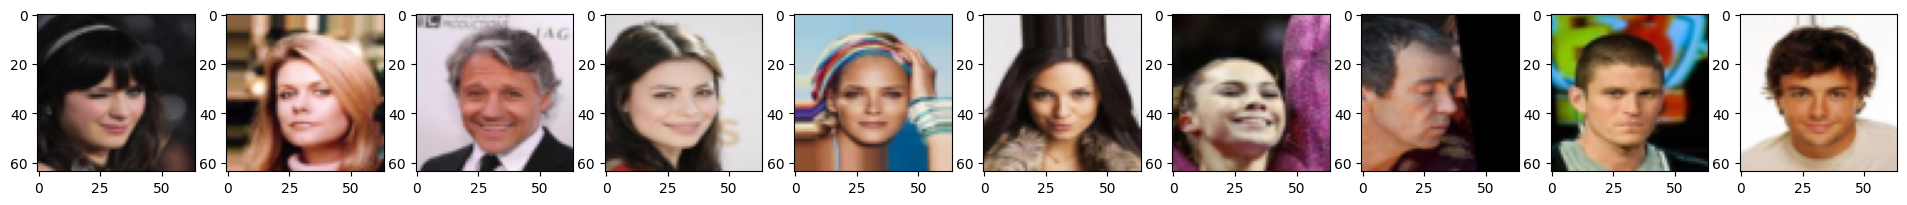

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

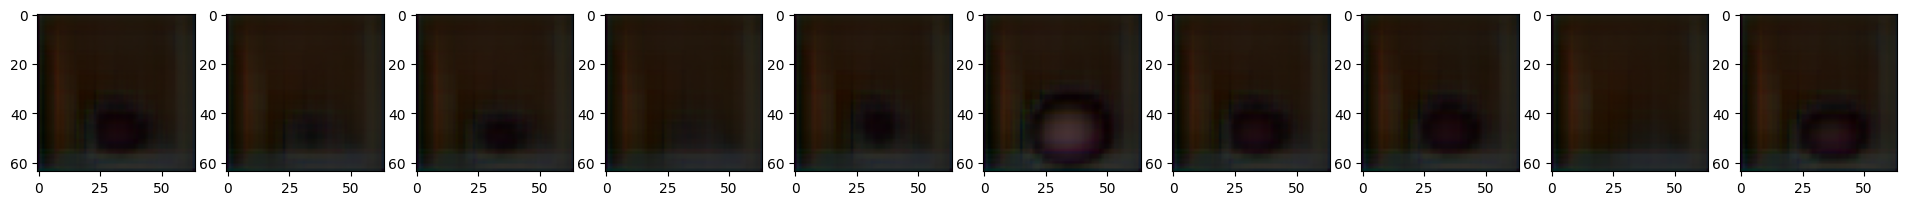

In [36]:
for X, y in train_dataloader:
    plot_img(X)
    mu, sigma = e(X.to(device))
    z = reparameterize(mu, sigma)
    x_fake = g(z)
    plot_img(x_fake)
    break